## Is it a car?

The following notebook is from the Deep Learning lecture by - Jeremy Howard

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "car photos"
1. Use DuckDuckGo to search for images of "truck photos"
1. Fine-tune a pre-trained neural network to recognize these two groups
1. Try running this model on a picture of a car and see if it works.

## Step 1: Download images of cars and trucks

In [2]:
!pip install duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.8 MB/s eta 0:00:0031m31.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.4 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a car photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('car photos', max_images=1)
urls[0]

'https://www.pixelstalk.net/wp-content/uploads/2016/08/Lamborghini-mountain-fog-sports-car-photos.jpg'

...and then download a URL and take a look at it:

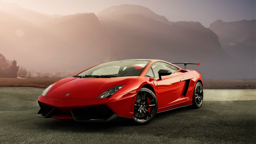

In [5]:
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "truck photos":

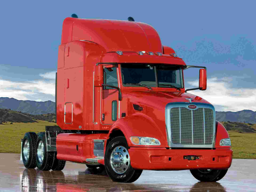

In [6]:
download_url(search_images('truck photos', max_images=1)[0], 'truck.jpg', show_progress=False)
Image.open('truck.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "car" and "truck" photos, and save each group of photos to a different folder:

In [7]:
searches = 'car','truck'
path = Path('car_or_truck')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/home/haops/miniforge3/envs/dling/lib/python3.9/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

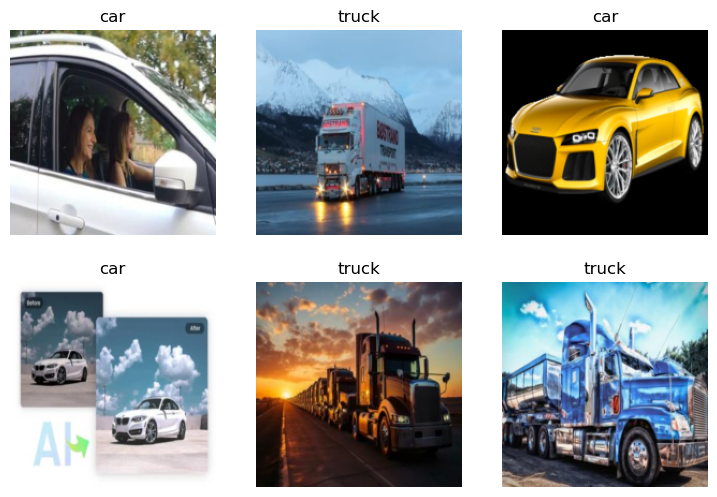

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "car" or "truck").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *car* or *truck*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.887935,0.451680,0.108108,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.182899,0.247559,0.094595,00:01
1,0.133587,0.175945,0.067568,00:01
2,0.107104,0.195799,0.081081,00:01
3,0.075746,0.158996,0.040541,00:01
4,0.070500,0.118350,0.054054,00:01
5,0.053586,0.124324,0.067568,00:01
6,0.043798,0.125127,0.067568,00:01
7,0.034596,0.114241,0.067568,00:01
8,0.030496,0.089737,0.040541,00:01
9,0.024797,0.095403,0.027027,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that car we downloaded at the start:

In [15]:
is_car,_,probs = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {is_car}.")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: car.
Probability it's a car: 1.0000


In [16]:
is_truck,_,probs = learn.predict(PILImage.create('truck.jpg'))
print(f"This is a: {is_truck}.")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: truck.
Probability it's a car: 0.0000


In [17]:
probs

tensor([3.3036e-06, 1.0000e+00])

In [18]:
is_truck

'truck'